# Applying Regression Techniques to Ames House Pricing WIP

In [526]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error
from xgboost import XGBRegressor, plot_importance, plot_tree
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from sklearn.feature_selection import mutual_info_regression
import warnings
import graphviz

warnings.simplefilter(action='ignore', category=FutureWarning)

SEED = 42

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

## EDA

In [527]:
base_path = "./house-prices-advanced-regression-techniques"
original_train = pd.read_csv(f"{base_path}/train.csv")

In [528]:
def get_original_train_df() -> pd.DataFrame:
    df = original_train.copy()
    df.drop("Id", axis=1, inplace=True)
    return df

In [529]:
eda_train = get_original_train_df()
eda_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [530]:
print(eda_train.shape)

(1460, 80)


In [531]:
eda_train.head(3)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  

[3 rows x 80 columns]

In [532]:
eda_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [533]:
px.histogram(eda_train, x="SalePrice", nbins=60, marginal="box")

In [534]:
categorical_columns = eda_train.select_dtypes(include=['object']).columns.tolist()
len(categorical_columns)

43

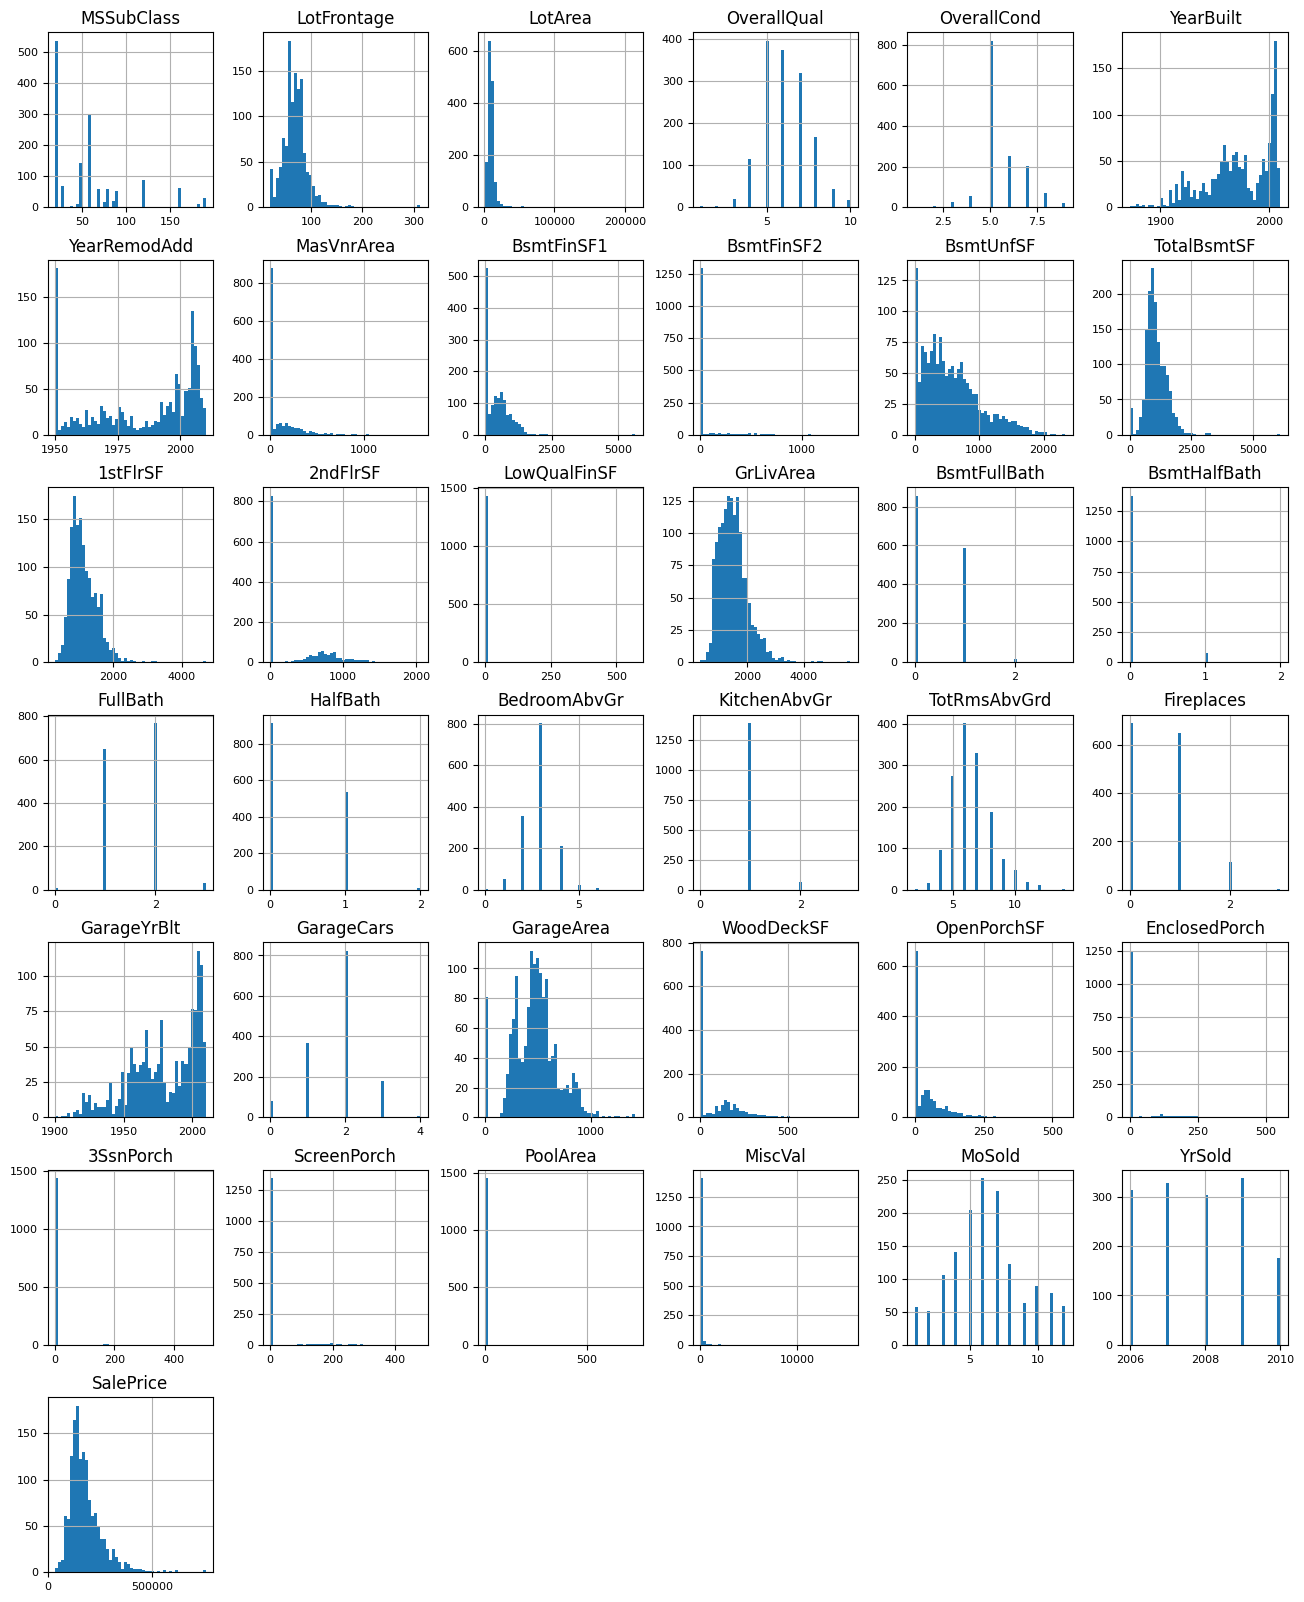

In [535]:
only_nums = eda_train.select_dtypes(include=["int64", "float64"])
only_nums.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Many numerical features are discrete. A lot of them have high frequency of 0 since eg not all houses have pools and such.

## Preprocessing

In [537]:
preprocessed_train_df = get_original_train_df()
na_counts = preprocessed_train_df.isna().sum()

print("Count of NA values in each column:")
print(na_counts)

Count of NA values in each column:
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF           

Numerical absent values will be replaced with 0, while categorical will be replaced with string "NA" just like data description.

In [536]:
# preprocessed_train_df[categorical_columns].fillna("NA", inplace=True)
# preprocessed_train_df.fillna(0, inplace=True)

for column in preprocessed_train_df.columns:
    if preprocessed_train_df[column].dtype == 'object':  # Categorical data
        preprocessed_train_df[column].fillna('NA', inplace=True)
        
    elif preprocessed_train_df[column].dtype in ["int64", "float64"]:  # Numerical data
        preprocessed_train_df[column].fillna(0, inplace=True)

In [538]:
na_counts = preprocessed_train_df.isna().sum()

print("Count of NA values in each column:")
print(na_counts)

Count of NA values in each column:
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF           

I'm gonna keep things simple for now and convert categorical features with label encoder since I don't think One-hot makes sense for most of these

In [539]:
preprocessed_train_df[categorical_columns].head(3)

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   

  Neighborhood Condition1  ... GarageType GarageFinish GarageQual GarageCond  \
0      CollgCr       Norm  ...     Attchd          RFn         TA         TA   
1      Veenker      Feedr  ...     Attchd          RFn         TA         TA   
2      CollgCr       Norm  ...     Attchd          RFn         TA         TA   

  PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
0          Y    NaN   NaN         NaN       WD        Normal  
1          Y    NaN   NaN         NaN       WD        Normal  
2          Y    NaN   NaN         NaN       WD        Normal  

[3 rows x 43 columns]

In [540]:
encoder = LabelEncoder()
for feat in categorical_columns:
    preprocessed_train_df[feat] = encoder.fit_transform(preprocessed_train_df[feat])

preprocessed_train_df[categorical_columns].head(3)

MSZoning  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0         3       1      2         3            3          0          4   
1         3       1      2         3            3          0          2   
2         3       1      2         0            3          0          4   

   LandSlope  Neighborhood  Condition1  ...  GarageType  GarageFinish  \
0          0             5           2  ...           1             1   
1          0            24           1  ...           1             1   
2          0             5           2  ...           1             1   

   GarageQual  GarageCond  PavedDrive  PoolQC  Fence  MiscFeature  SaleType  \
0           4           4           2       3      4            4         8   
1           4           4           2       3      4            4         8   
2           4           4           2       3      4            4         8   

   SaleCondition  
0              4  
1              4  
2              4  

[3 rows x 43 columns]

Using LabelEncoder is mostly suboptimal given that the model might misinterpret some features as having a sense of ordinality that they do not in fact have

In [541]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for column in df.columns:
        if df[column].dtype == 'object':  # Categorical data
            df[column].fillna('NA', inplace=True)
            
        elif df[column].dtype in ["int64", "float64"]:  # Numerical data
            df[column].fillna(0, inplace=True)

    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    encoder = LabelEncoder()
    for feat in categorical_columns:
        df[feat] = encoder.fit_transform(df[feat])
    
    return df

## Linear Regression

In [544]:
df_r = get_original_train_df()
df_r = preprocess(df_r)
X_r = df_r.drop("SalePrice", axis=1, inplace=False)
y_r = df_r["SalePrice"].copy()
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.3, shuffle=True)

In [545]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_r, y_train_r)

LinearRegression()

### Predictions

In [546]:
y_pred_r = linear_reg.predict(X_test_r)
print((y_pred_r < 0).any())
# score_lrmse_r = rmse_log(y_pred_r, y_test_r)
score_lrmse_r = root_mean_squared_log_error(y_test_r, y_pred_r)
score_rmse_r = root_mean_squared_error(y_test_r, y_pred_r)
print(f"Log RMSE: {score_lrmse_r}")
print(f"RMSE: {score_rmse_r}")

False
Log RMSE: 0.19489012489199634
RMSE: 49599.49730723921


### Visualizing predictions and true values over GrLivArea

In [596]:
df = X_test_r.copy()
df["predicted"] = y_pred_r
df["actual"] = y_test_r

fig = px.scatter(df, x='GrLivArea', y='actual', title='GrLivArea vs SalePrice Scatter Plot', labels={"actual": "Actual"})
fig.add_scatter(x=df['GrLivArea'], y=df['predicted'], mode='markers', name="Predicted")
fig.show()

## XGBoost

In [548]:
xgbr = XGBRegressor(seed = SEED)
xgbr.fit(X_train_r, y_train_r)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Default XGBRegressor Predictions

In [549]:
y_pred_xgbr = xgbr.predict(X_test_r)
score_lrmse_r = root_mean_squared_log_error(y_test_r, y_pred_xgbr)
score_rmse_r = root_mean_squared_error(y_test_r, y_pred_xgbr)
print(f"Log RMSE: {score_lrmse_r}")
print(f"RMSE: {score_rmse_r}")

Log RMSE: 0.15299252268589675
RMSE: 39665.293079238356


#### Tree Visualization

<Figure size 12000x6000 with 0 Axes>

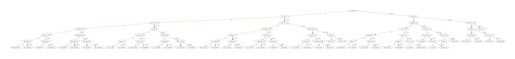

In [550]:
plt.figure(figsize=(20, 10), dpi=600)
plot_tree(xgbr)  # prints the first tree
plt.show()

Resolution is incredibly bad but we can visually infer that the default XGBRegressor produces a large and relatively deep tree

Baseline XGBRegressor has considerable error improvements over LinearRegressor. And that's with horrible feature selection and no tuning. Let's tune it

### Hyperparam Tuning on XGBRegressor

In [551]:
# hyperparameter search space
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform("n_estimators", 150, 250, 20),
    'seed': 0
}

# objective function that returns the score
def objective(space):
    clf=XGBRegressor(
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        eval_metric="rmse",
        early_stopping_rounds=10,
        seed = SEED
    )
    
    evaluation = [(X_train_r, y_train_r), (X_test_r, y_test_r)]
    
    clf.fit(
        X_train_r, y_train_r,
        eval_set=evaluation, 
        verbose=True
    )
    

    pred = clf.predict(X_test_r)
    loss = root_mean_squared_error(y_test_r, pred)
    print ("SCORE:", loss)
    return {"loss": loss, "model": clf, "status": STATUS_OK}

trials = Trials()
best_hyperparams = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

def get_best_model_from_trials(trials):
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]

    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]

    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['model']

  0%|                                   | 0/100 [00:00<?, ?trial/s, best loss=?]

[0]	validation_0-rmse:62873.16715	validation_1-rmse:55075.08965                 
[1]	validation_0-rmse:48694.37189	validation_1-rmse:42949.47989                 
[2]	validation_0-rmse:38679.15360	validation_1-rmse:37405.80327                 
[3]	validation_0-rmse:31333.67749	validation_1-rmse:35442.94851                 
[4]	validation_0-rmse:26548.13575	validation_1-rmse:35229.53428                 
[5]	validation_0-rmse:22845.17421	validation_1-rmse:35519.00668                 
[6]	validation_0-rmse:20197.65982	validation_1-rmse:35915.05778                 
[7]	validation_0-rmse:18356.19027	validation_1-rmse:36159.66131                 
[8]	validation_0-rmse:17135.44507	validation_1-rmse:36689.39235                 
[9]	validation_0-rmse:16111.47250	validation_1-rmse:37534.35285                 
[10]	validation_0-rmse:15390.23577	validation_1-rmse:37865.41799                
[11]	validation_0-rmse:14876.05109	validation_1-rmse:38010.10951                
[12]	validation_0-rmse:14484

In [552]:
best_hyperparams

{'colsample_bytree': 0.6089864170351417,
 'gamma': 5.176243723860369,
 'max_depth': 8.0,
 'min_child_weight': 8.0,
 'n_estimators': 160.0,
 'reg_alpha': 180.0,
 'reg_lambda': 0.1950024574093424}

In [553]:
final_xgb = get_best_model_from_trials(trials)
# final_xgb.fit(X_train_r, y_train_r)
final_xgb_pred = final_xgb.predict(X_test_r)

score_lrmse_r = root_mean_squared_log_error(y_test_r, final_xgb_pred)
score_rmse_r = root_mean_squared_error(y_test_r, final_xgb_pred)
print(f"Log RMSE: {score_lrmse_r}")
print(f"RMSE: {score_rmse_r}")

Log RMSE: 0.16603654357761974
RMSE: 33744.96681621192


#### Visualizing tree and Feature Importance

<Figure size 12000x6000 with 0 Axes>

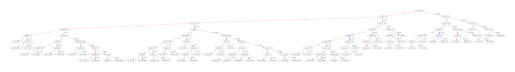

In [554]:
plt.figure(figsize=(20, 10), dpi=600)
plot_tree(final_xgb)  # prints the first tree
plt.show()

Tuned XGB reduces tree size. This might be indicative that tuning hyperparams reduced risk of overfitting

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

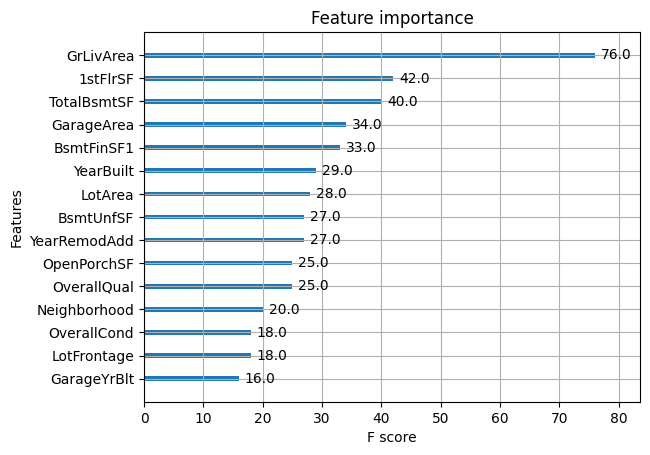

In [555]:
plot_importance(final_xgb, max_num_features=15)

## Improving Performance via a simple Feature Engineering

Mutual Information between two features measures how much the knowledge of one of them reduces uncertainty about the other one, thus detecting what kind of relationship they have, if any, and it's not limited to linear relationships like correlation.

"Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target." Source: [Kaggle](https://www.kaggle.com/code/ryanholbrook/mutual-information)

"Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association." Source: [Kaggle](https://www.kaggle.com/code/ryanholbrook/mutual-information)

In [556]:
fe_df = get_original_train_df()
print(fe_df.head(3))
X_fe = fe_df.copy().drop("SalePrice", axis = 1)
y_fe = fe_df.copy()["SalePrice"]
X_fe = preprocess(X_fe)
(X_fe.head(3))

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  

[3 rows x 80 columns]


MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0          60         3         65.0     8450       1      1         3   
1          20         3         80.0     9600       1      1         3   
2          60         3         68.0    11250       1      1         0   

   LandContour  Utilities  LotConfig  ...  ScreenPorch  PoolArea  PoolQC  \
0            3          0          4  ...            0         0       3   
1            3          0          2  ...            0         0       3   
2            3          0          4  ...            0         0       3   

   Fence  MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0      4            1        0       2    2008         8              4  
1      4            1        0       5    2007         8              4  
2      4            1        0       9    2008         8              4  

[3 rows x 79 columns]

In [557]:
X_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int64  
 5   Alley          1460 non-null   int64  
 6   LotShape       1460 non-null   int64  
 7   LandContour    1460 non-null   int64  
 8   Utilities      1460 non-null   int64  
 9   LotConfig      1460 non-null   int64  
 10  LandSlope      1460 non-null   int64  
 11  Neighborhood   1460 non-null   int64  
 12  Condition1     1460 non-null   int64  
 13  Condition2     1460 non-null   int64  
 14  BldgType       1460 non-null   int64  
 15  HouseStyle     1460 non-null   int64  
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

All discrete features must be int for scikit-learn's MI to work properly

In [558]:
disc_features = X_fe.dtypes == int
disc_features

MSSubClass        True
MSZoning          True
LotFrontage      False
LotArea           True
Street            True
Alley             True
LotShape          True
LandContour       True
Utilities         True
LotConfig         True
LandSlope         True
Neighborhood      True
Condition1        True
Condition2        True
BldgType          True
HouseStyle        True
OverallQual       True
OverallCond       True
YearBuilt         True
YearRemodAdd      True
RoofStyle         True
RoofMatl          True
Exterior1st       True
Exterior2nd       True
MasVnrType        True
MasVnrArea       False
ExterQual         True
ExterCond         True
Foundation        True
BsmtQual          True
BsmtCond          True
BsmtExposure      True
BsmtFinType1      True
BsmtFinSF1        True
BsmtFinType2      True
BsmtFinSF2        True
BsmtUnfSF         True
TotalBsmtSF       True
Heating           True
HeatingQC         True
CentralAir        True
Electrical        True
1stFlrSF          True
2ndFlrSF   

In [559]:
def plot_mi_scores(scores, n_features = len(X_fe)):
    scores = scores.sort_values(ascending=True)[-n_features :]
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_fe, y_fe, disc_features)
mi_scores.head(10)  # show a few features with their MI scores

OverallQual     0.573400
Neighborhood    0.530068
GarageArea      0.495235
GrLivArea       0.431887
YearBuilt       0.409197
TotalBsmtSF     0.399570
LotArea         0.394227
GarageCars      0.369763
KitchenQual     0.332018
BsmtQual        0.328852
Name: MI Scores, dtype: float64

In [560]:
top_20_mi_features = mi_scores.index[:20].tolist()
top_20_mi_features

['OverallQual',
 'Neighborhood',
 'GarageArea',
 'GrLivArea',
 'YearBuilt',
 'TotalBsmtSF',
 'LotArea',
 'GarageCars',
 'KitchenQual',
 'BsmtQual',
 'ExterQual',
 '1stFlrSF',
 'MSSubClass',
 'YearRemodAdd',
 'FullBath',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'FireplaceQu',
 'TotRmsAbvGrd']

In [598]:
least_informative_10_features = mi_scores.index[-10 :].tolist()
least_informative_10_features

['LandSlope',
 '3SsnPorch',
 'Condition2',
 'Utilities',
 'PoolArea',
 'Street',
 'BsmtFinSF2',
 'PoolQC',
 'MoSold',
 'YrSold']

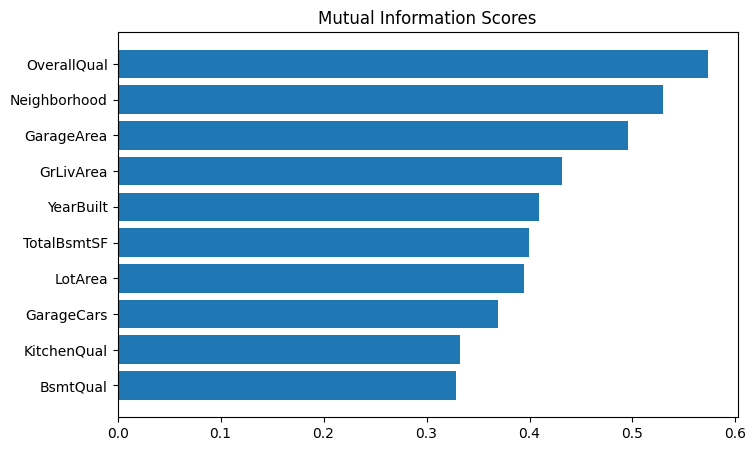

In [562]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores, n_features=10)

In [563]:
px.scatter(fe_df, x="OverallQual", y="SalePrice")

In [564]:
px.scatter(fe_df, x="Neighborhood", y="SalePrice")

In [565]:
px.scatter(fe_df, x="GarageArea", y="SalePrice")

In [566]:
px.scatter(fe_df, x="GrLivArea", y="SalePrice")

Total Outside Area

In [567]:
fe_df["TotalOutsideSF"] = fe_df["WoodDeckSF"] + fe_df["EnclosedPorch"] + fe_df["3SsnPorch"] + fe_df["ScreenPorch"]

fe_df[["TotalOutsideSF", "SalePrice"]].head(3)

TotalOutsideSF  SalePrice
0               0     208500
1             298     181500
2               0     223500

Ratio of total house area and room count. Could indicate Spaciousness. Source: [Creating Features lesson on Kaggle](https://www.kaggle.com/code/ryanholbrook/creating-features)

In [568]:
fe_df["TotalHouseAreaOverRms"] = (fe_df["1stFlrSF"] + fe_df["2ndFlrSF"]) / fe_df["TotRmsAbvGrd"]

fe_df[["TotalHouseAreaOverRms", "SalePrice"]].head(3)

TotalHouseAreaOverRms  SalePrice
0             213.750000     208500
1             210.333333     181500
2             297.666667     223500

Median Overall quality by neighborhood

In [569]:
fe_df["MedNhbdQual"] = (
    fe_df.groupby('Neighborhood')
    ['OverallQual']
    .transform('median')
)

fe_df[["MedNhbdQual", "SalePrice"]].head(5)

MedNhbdQual  SalePrice
0          7.0     208500
1          6.0     181500
2          7.0     223500
3          6.0     140000
4          8.0     250000

Mean GrLivArea by Neighborhood

In [570]:
fe_df["MeanNhbdArea"] = (
    fe_df.groupby('Neighborhood')
    ['GrLivArea']
    .transform('mean')
)

fe_df[["MeanNhbdArea", "SalePrice"]].head(5)

MeanNhbdArea  SalePrice
0   1480.500000     208500
1   1539.636364     181500
2   1480.500000     223500
3   1791.607843     140000
4   2508.853659     250000

In [571]:
def feature_engineer_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["TotalOutsideSF"] = df["WoodDeckSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
    df["TotalHouseAreaOverRms"] = (df["1stFlrSF"] + df["2ndFlrSF"]) / df["TotRmsAbvGrd"]
    df["MedNhbdQual"] = (
        df.groupby('Neighborhood')
        ['OverallQual']
        .transform('median')
    )
    df["MeanNhbdArea"] = (
        df.groupby('Neighborhood')
        ['GrLivArea']
        .transform('mean')
    )

    return df

In [572]:
fe_df.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... MiscVal MoSold YrSold SaleType  \
0         Lvl    AllPub    Inside  ...       0      2   2008       WD   
1         Lvl    AllPub       FR2  ...       0      5   2007       WD   
2         Lvl    AllPub    Inside  ...       0      9   2008       WD   
3         Lvl    AllPub    Corner  ...       0      2   2006       WD   
4         Lvl    AllPub       FR2  ...       0     12   2008       WD   

  SaleCondition SalePrice  TotalOutsideSF  TotalHouseAreaOverRms  MedNhbdQual  \
0        Normal    208500               0             213.750000          7.0   
1        Normal    181500             298             210.333333          6.0   
2        Normal    223500               0             297.666667          7.0   
3       Abnorml    140000             272             245.285714          6.0   
4        Normal    250000             192             244.222222          8.0   

   MeanNhbdArea  
0   1480.500000  
1   1539.636364  
2   1480.500000  
3   1791.607843  
4   2508.853659  

[5 rows x 84 columns]

In [573]:
fe_df = preprocess(fe_df)
fe_df.head(5)

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0          60         3         65.0     8450       1      1         3   
1          20         3         80.0     9600       1      1         3   
2          60         3         68.0    11250       1      1         0   
3          70         3         60.0     9550       1      1         0   
4          60         3         84.0    14260       1      1         0   

   LandContour  Utilities  LotConfig  ...  MiscVal  MoSold  YrSold  SaleType  \
0            3          0          4  ...        0       2    2008         8   
1            3          0          2  ...        0       5    2007         8   
2            3          0          4  ...        0       9    2008         8   
3            3          0          0  ...        0       2    2006         8   
4            3          0          2  ...        0      12    2008         8   

   SaleCondition  SalePrice  TotalOutsideSF  TotalHouseAreaOverRms  \
0              4     208500               0             213.750000   
1              4     181500             298             210.333333   
2              4     223500               0             297.666667   
3              0     140000             272             245.285714   
4              4     250000             192             244.222222   

   MedNhbdQual  MeanNhbdArea  
0          7.0   1480.500000  
1          6.0   1539.636364  
2          7.0   1480.500000  
3          6.0   1791.607843  
4          8.0   2508.853659  

[5 rows x 84 columns]

In [574]:
X = fe_df.drop("SalePrice", axis=1)
y = fe_df["SalePrice"]

disc_features_final = X.dtypes == int
mi_scores2 = make_mi_scores(X, y, disc_features_final)
mi_scores2

OverallQual              5.703870e-01
Neighborhood             5.351264e-01
GarageArea               4.999674e-01
GrLivArea                4.355573e-01
MeanNhbdArea             4.297684e-01
YearBuilt                4.104165e-01
TotalBsmtSF              4.022577e-01
LotArea                  3.929570e-01
GarageCars               3.744734e-01
MedNhbdQual              3.716946e-01
BsmtQual                 3.375635e-01
ExterQual                3.349768e-01
KitchenQual              3.272504e-01
1stFlrSF                 2.855243e-01
MSSubClass               2.785334e-01
YearRemodAdd             2.768655e-01
GarageFinish             2.656193e-01
FullBath                 2.628154e-01
GarageYrBlt              2.525708e-01
TotalHouseAreaOverRms    2.505986e-01
LotFrontage              2.132196e-01
GarageType               2.101758e-01
TotRmsAbvGrd             2.082033e-01
FireplaceQu              2.080325e-01
Foundation               1.965026e-01
OpenPorchSF              1.941991e-01
Fireplaces  

## XGBoost with new engineered features

In [575]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [576]:
# objective function that returns the score
def objective2(space):
    clf=XGBRegressor(
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        eval_metric="rmse",
        early_stopping_rounds=10,
        seed=SEED
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(
        X_train, y_train,
        eval_set=evaluation, 
        verbose=True
    )
    

    pred = clf.predict(X_test)
    loss = root_mean_squared_error(y_test, pred)
    print ("SCORE:", loss)
    return {"loss": loss, "model": clf, "status": STATUS_OK}

trials2 = Trials()
best_hyperparams = fmin(
    fn = objective2,
    space = space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials2
)

[0]	validation_0-rmse:59739.34587	validation_1-rmse:63584.76254                 
[1]	validation_0-rmse:45828.83888	validation_1-rmse:51150.16481                 
[2]	validation_0-rmse:35882.66175	validation_1-rmse:43016.47943                 
[3]	validation_0-rmse:28714.48257	validation_1-rmse:37477.22449                 
[4]	validation_0-rmse:23599.03482	validation_1-rmse:33697.49648                 


[5]	validation_0-rmse:19893.93340	validation_1-rmse:31584.28989
[6]	validation_0-rmse:17371.53939	validation_1-rmse:29816.80461                 
[7]	validation_0-rmse:15232.83779	validation_1-rmse:29158.94254                 
[8]	validation_0-rmse:13589.33397	validation_1-rmse:28455.87173                 
[9]	validation_0-rmse:12294.84180	validation_1-rmse:28253.07661                 
[10]	validation_0-rmse:11310.48789	validation_1-rmse:27938.81401                
[11]	validation_0-rmse:10283.19786	validation_1-rmse:27848.79034                
[12]	validation_0-rmse:9658.02454	validation_1-rmse:27534.77573                 
[13]	validation_0-rmse:9180.47771	validation_1-rmse:27348.16243                 
[14]	validation_0-rmse:8728.40178	validation_1-rmse:27171.64236                 
[15]	validation_0-rmse:8231.08768	validation_1-rmse:27009.01550                 
[16]	validation_0-rmse:7957.96547	validation_1-rmse:26973.12489                 
[17]	validation_0-rmse:7702.51477	validation_

In [577]:
submission_xgb = get_best_model_from_trials(trials2)
submission_xgb_pred = submission_xgb.predict(X_test)

score_lrmse_sub = root_mean_squared_log_error(y_test, submission_xgb_pred)
score_rmse_sub = root_mean_squared_error(y_test, submission_xgb_pred)
print(f"Log RMSE: {score_lrmse_sub}")
print(f"RMSE: {score_rmse_sub}")

Log RMSE: 0.14291852074526581
RMSE: 25290.328219419407


Through Feature Engineering, Log RMSE had a considerable improvement

<Figure size 12000x6000 with 0 Axes>

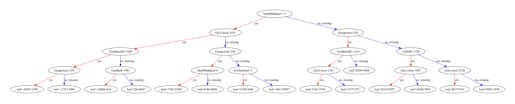

In [578]:
plt.figure(figsize=(20, 10), dpi=600)
plot_tree(submission_xgb)  # prints the first tree
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

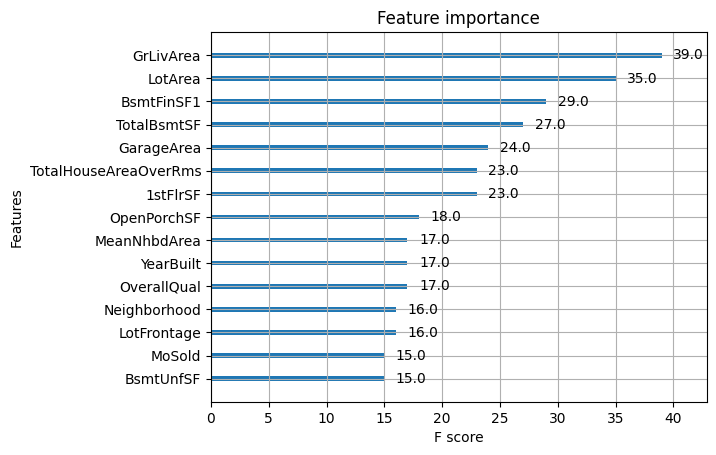

In [579]:
plot_importance(submission_xgb, max_num_features=15)

We see that a couple of engineered features gained a relevant position on the Feature Importance ranking

In [597]:
df = X_test.copy()
df["predicted"] = submission_xgb_pred
df["actual"] = y_test

fig = px.scatter(df, x='GrLivArea', y='actual', title='GrLivArea vs SalePrice Scatter Plot')
fig.add_scatter(x=df['GrLivArea'], y=df['predicted'], mode='markers', name="Predicted")
fig.show()

## Experiment

In [644]:
exp_df = feature_engineer_df(get_original_train_df())

X = exp_df.drop("SalePrice", axis=1)
y = exp_df["SalePrice"]

# X.drop(least_informative_10_features, axis=1, inplace=True)
X = preprocess(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [649]:
# objective function that returns the score
def objective3(space):
    clf=XGBRegressor(
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        eval_metric="rmse",
        early_stopping_rounds=10,
        seed=SEED
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(
        X_train, y_train,
        eval_set=evaluation, 
        verbose=True
    )
    

    pred = clf.predict(X_test)
    loss = root_mean_squared_error(y_test, pred)
    print ("SCORE:", loss)
    return {"loss": loss, "model": clf, "status": STATUS_OK}

trials3 = Trials()
best_hyperparams = fmin(
    fn = objective3,
    space = space,
    algo = tpe.suggest,
    max_evals = 500,
    trials = trials3
)

exp_xgb = get_best_model_from_trials(trials3)
exp_xgb_pred = exp_xgb.predict(X_test)

score_lrmse_exp = root_mean_squared_log_error(y_test, exp_xgb_pred)
score_rmse_exp = root_mean_squared_error(y_test, exp_xgb_pred)
print(f"Log RMSE: {score_lrmse_exp}")
print(f"RMSE: {score_rmse_exp}")

[0]	validation_0-rmse:61250.65294	validation_1-rmse:58945.64782                 
[1]	validation_0-rmse:46323.82728	validation_1-rmse:47486.47146                 
[2]	validation_0-rmse:35892.51697	validation_1-rmse:40901.28165                 
[3]	validation_0-rmse:27961.68955	validation_1-rmse:36304.79739                 
[4]	validation_0-rmse:22192.31095	validation_1-rmse:33304.72298                 
[5]	validation_0-rmse:18072.85350	validation_1-rmse:31793.41064                 
[6]	validation_0-rmse:14866.60161	validation_1-rmse:31291.36383                 
[7]	validation_0-rmse:12389.93502	validation_1-rmse:30507.25418                 
[8]	validation_0-rmse:10600.88786	validation_1-rmse:30409.23735                 
[9]	validation_0-rmse:9298.10674	validation_1-rmse:30379.95215                  
[10]	validation_0-rmse:8198.59244	validation_1-rmse:30116.40832                 
[11]	validation_0-rmse:7239.87369	validation_1-rmse:29993.19087                 
[12]	validation_0-rmse:6551.

[11]	validation_0-rmse:7525.60363	validation_1-rmse:32125.50806                 
[12]	validation_0-rmse:6918.03916	validation_1-rmse:31752.43498                 
[13]	validation_0-rmse:6469.90232	validation_1-rmse:31831.24315                 
[14]	validation_0-rmse:6061.39596	validation_1-rmse:31697.82482                 
[15]	validation_0-rmse:5479.97027	validation_1-rmse:31424.75040                 
[16]	validation_0-rmse:5243.85364	validation_1-rmse:31364.60756                 
[17]	validation_0-rmse:4965.49870	validation_1-rmse:31251.80624                 
[18]	validation_0-rmse:4676.85515	validation_1-rmse:31371.55757                 
[19]	validation_0-rmse:4461.86520	validation_1-rmse:31339.76723                 
[20]	validation_0-rmse:4181.43145	validation_1-rmse:31486.99816                 
[21]	validation_0-rmse:3958.79286	validation_1-rmse:31336.93757                 
[22]	validation_0-rmse:3757.27940	validation_1-rmse:31412.45950                 
[23]	validation_0-rmse:3556.

There is a slight improvement in RMSLE performance by dropping the least informative features and having hyperopt evaluate performance by RMSE instead of RMSLE

## Submission

In [645]:
original_test = pd.DataFrame(pd.read_csv(f"{base_path}/test.csv"))
test_ids = original_test.Id
original_test.drop("Id", axis = 1, inplace=True)

In [646]:
original_test.head(3)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          20       RH         80.0    11622   Pave   NaN      Reg   
1          20       RL         81.0    14267   Pave   NaN      IR1   
2          60       RL         74.0    13830   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       6    2010        WD         Normal  
1        Gar2   12500       6    2010        WD         Normal  
2         NaN       0       3    2010        WD         Normal  

[3 rows x 79 columns]

In [647]:
original_test.shape

(1459, 79)

In [648]:
test_df = preprocess(original_test)
test_df.head(3)

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0          20         3         80.0    11622       1      1         3   
1          20         4         81.0    14267       1      1         0   
2          60         4         74.0    13830       1      1         0   

   LandContour  Utilities  LotConfig  ...  ScreenPorch  PoolArea  PoolQC  \
0            3          0          4  ...          120         0       2   
1            3          0          0  ...            0         0       2   
2            3          0          4  ...            0         0       2   

   Fence  MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0      2            1        0       6    2010         9              4  
1      4            0    12500       6    2010         9              4  
2      2            1        0       3    2010         9              4  

[3 rows x 79 columns]

In [651]:
test_df.shape

(1459, 83)

In [650]:
test_df = feature_engineer_df(test_df)
# test_df = test_df.drop(least_informative_10_features, axis=1)

In [652]:
# final_pred = final_xgb.predict(test_df)
# final_pred = submission_xgb.predict(test_df)
final_pred = exp_xgb.predict(test_df)
series = pd.Series(final_pred, name = "SalePrice")
series.index = test_ids
series.to_csv("submission.csv", index_label= "Id")

# TODO

- Create new features (maybe with K-Means?)
- PCA
- Evaluate if LabelEncoder is the best approach